-----

# **BrainStation Bootcamp:**
### **Amazon Book Recommendation System**
* Author: Rurick Alejandro Granados Figueredo
* Contact: rurickgrfi@gmail.com
* Date: August, 2023
-----------

## **Project Overview**
Discovering the perfect book that aligns with our personal preferences can be challenging, especially for those who are not regular readers. In my capstone project, I have chosen to address this issue by building a book recommendation system. By developing this tool, I aim to predict and suggest books that individuals would enjoy reading, making the process of book selection easier and more personalized.




---


## **Table of Contents** 
---
- [1. Loading Data and Libraries Setup](#_1)  
- [2. Data Preparation and Exploration](#_2)
    - [2.1 `ratings` data exploration](#_2.1)    
        - [2.1.1 Cleaning `ratings`](#_2.1.1) 
        - [2.1.2 Feature Engineering](#_2.1.2) 
    - [2.2 `books` data exploration](#_2.2) 
        - [2.2.1 Cleaning `books`](#_2.2.1) 
        - [2.2.2 Feature Engineering](#_2.2.2) 
- [3. Merging `books` and `ratings_df` data frames](#_3)
- [4. Data visualization](#_4)
- [5. Data for the recommendation system](#_5)
    - [Data Transformation](#_6)
- [6. Modeling recommender system](#_6)
    - [6.1 User Independent System](#_6.1)
    - [6.2 Content Based Recommendations](#_6.2)
    - [6.3 Collaborative Based Recommendations - NEEDS WORK](#_6.3)
    - [6.4 Matrix Factorization Methods and Latent Features - NEEDS WORK](#_6.4)



-----

## 1. Loading Data and Libraries Setup <a class="anchor" id="_1"></a>

In [245]:
# Import all the libraries needed for the project
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Libraries for Content Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Libraries for FunkSVD
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD


In [246]:
# Read the Books_rating csv file and asigne it to a data frame ratings
ratings = pd.read_csv('Books_rating.csv')

In [247]:
# Read the Books_data csv file and asigne it to a data frame books
books = pd.read_csv('books_data.csv')

/var/folders/y4/5n9w7q191lx6764p508p49_w0000gn/T/ipykernel_39615/3441828521.py:2: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('books_data.csv')


## 2. Data Preparation and Exploration <a class="anchor" id="_2"></a>

### 2.1 `ratings` data exploration <a class="anchor" id="_2.1"></a>

In [248]:
ratings.sample(1)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
1795773,B000MKFNF0,Lonesome Dove,NaN,A36ZC9726STX64,Linda B Estes,0/0,5.0,985219200,McMurtry's subjects and treatment are bound to...,When McMurtry brought Call and Gus to life in ...


In [249]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB


In [250]:
# ratings shape
print(f"Total rows: {ratings.shape[0]}")
print(f"Total columns: {ratings.shape[1]}")
print(f"Null values: {ratings.isna().sum().sum()}")

Total rows: 3000000
Total columns: 10
Null values: 3643144


In [251]:
# ratings NaN values
ratings.isna().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64

#### 2.1.1 Cleaning `ratings` data frame: <a class="anchor" id="_2.1.1"></a>

##### A. Droping NaN values (Title, User_id)
- The `Title` and `User_id` columns are essential for the project, and therefore, any rows with NaN values in these columns will be removed.

In [252]:
ratings.dropna(subset=["Title","User_id"],inplace = True)

In [253]:
ratings.isna().sum()

Id                          0
Title                       0
Price                 2023443
User_id                     0
profileName               118
review/helpfulness          0
review/score                0
review/time                 0
review/summary            397
review/text                 1
dtype: int64

The `review/text` and  `review/summary` columns have 1 and 29 NaN values each, since this amounts are not significant, those records will be droped.

In [254]:
# drop review/summary NaN values
ratings.dropna(subset=["review/summary"],inplace = True)

# drop review/text NaN values
ratings.dropna(subset=["review/text"],inplace = True)

In [255]:
ratings.shape

(2437620, 10)

##### B. Duplicate rows

In [256]:
# Calculate the number of duplicated rows
ratings.duplicated().sum()

5546

In [257]:
# Drop the duplicated rows
ratings.drop_duplicates(inplace=True)
ratings.shape

(2432074, 10)

##### C. Cleanign Title column

In [258]:
# Cleaning title column from ratings data frame

# Remove the extra space from the title column
ratings['Title'] = ratings['Title'].str.strip()

# remove the punctuation from the Title column
ratings['Title'] = ratings['Title'].str.replace('[^\w\s]','')

In [259]:
clean_title = ratings['Title'].value_counts()
clean_title.head(35)

Title
The Hobbit                                                             17854
Pride and Prejudice                                                    17739
Atlas Shrugged                                                         10741
Wuthering Heights                                                       8570
Great Expectations                                                      5648
Mere Christianity                                                       5495
The Picture of Dorian Gray                                              5280
Persuasion                                                              5160
Brave New World                                                         5124
Of Mice and Men                                                         4613
The Great Gatsby                                                        4284
The Scarlet Letter A Romance                                            3841
The Giver                                                             

In [260]:
# Identify the number of unique users and titles
print("Shape:", ratings.shape)
print("Number of Unique Users:",len(ratings["User_id"].unique()))
print("Number of Unique Titles:",len(ratings["Title"].unique()))

Shape: (2432074, 10)
Number of Unique Users: 1008822
Number of Unique Titles: 206706


#### 2.1.2 `ratings` feature engineering: <a class="anchor" id="_2.1.2"></a>

In [261]:
ratings.sample(1)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
26476,B0006A011C,Ransom,NaN,A1HPMQINW6RW9T,Jenene N. Pope,1/1,5.0,964569600,LOVED THE BOOK,I read this book last year when it came out an...


- #### A. New column: Review_Counts

In [262]:
# Create a new variable with the number records per each title
title_counts = ratings['Title'].value_counts()
title_counts.head(5)

Title
The Hobbit             17854
Pride and Prejudice    17739
Atlas Shrugged         10741
Wuthering Heights       8570
Great Expectations      5648
Name: count, dtype: int64

In [263]:
# The number of records per title is equal to the number of reviews per title, 
# Therefore we can create a new column to the ratings data frame with the number of reviews per title `Review_Counts`
ratings["Review_Counts"] = ratings["Title"].map(title_counts)
ratings.sample(3)

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,Review_Counts
2668298,B000GVI7JY,Cold Mountain,NaN,A1NL6NAWB5BTNF,Alexis Saba,0/0,4.0,977788800,Truly provides a life lesson,I chose this book out of many recommended by m...,782
242111,B000NGRMTS,A Clockwork Orange,NaN,A3PG4Q11V0E0PO,"Patricia White ""believer'piseces""",1/3,5.0,1121472000,Powerfull Novel,I don't know what's wrong with some of you peo...,1105
208569,055214245X,Gift,NaN,A33KT4LAR8EAME,Heather,1/1,5.0,1015891200,The Gift,"The author, Danielle Steel, caught my eye righ...",63


In [264]:
# Checking the new column Review_Counts
# Searching the review Id=B000NBH78O to verify the Review_Counts column
ratings[ratings["Id"] == "B000NBH78O"]

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,Review_Counts
2363198,B000NBH78O,"French Hand Sewing, Vol. 1",NaN,A1PHDSHG09FQYT,Virginia Popper,2/3,5.0,1187136000,Essential Reference,I am glad that out-of-print books are so readi...,4
2363199,B000NBH78O,"French Hand Sewing, Vol. 1",NaN,A3TVB34TUT4DOF,T.Lizzee,0/0,5.0,1355875200,By the master of French hand sewing,"Beautiful book, the only one I have found with...",4
2363200,B000NBH78O,"French Hand Sewing, Vol. 1",NaN,A6RDL9WUMSGWA,S. Roncevaux,0/0,5.0,1289433600,A Great Book!,I haven't put the instructions to actual pract...,4
2363201,B000NBH78O,"French Hand Sewing, Vol. 1",NaN,A29HWEN7ZBFENT,wild child's mom,0/0,5.0,1252713600,Fabulous!,This invaluable book covers all aspects of bea...,4


- #### B. Selecting Columns for the desired data frame
    - `Price`: Will not be consider for the analysis due to having 2023443 NaN vaules which is around 82% of the records. 
    - `profileName`: Will not be consider for the analysis since we would use `User_id` as the identifier.
    - `review/time`, `review/helpfulness` : Will not be consider for the analysis.

In [265]:
rating_df = ratings[["Id","Title","User_id","review/score","review/summary","review/text","Review_Counts"]]

rating_df = rating_df.rename(columns={
    "Id": "RatingID",
    "Title": "BookTitle",
    "User_id": "UserID",
    "review/score": "Review_Score",
    "review/summary": "Review_Summary",
    "review/text": "Review_Text",
    "Review_Counts": "Review_Counts"
})

rating_df.sample(3)

,RatingID,BookTitle,UserID,Review_Score,Review_Summary,Review_Text,Review_Counts
1939223,B0009K762Q,The News from Paraguay : A Novel,A1ZOBNDLY8M0AA,2.0,Where's the Beef?,Clara Peller's immortal line in the old burger...,43
828020,1593355548,Wuthering Heights,A11HCTHM2K2IN4,4.0,A book for the romantic,"Opion of Book:The book was pretty good, but a ...",8570
1056410,B0007HPUV0,Hiroshima,A3H2CKTFZ3B3GD,5.0,Testament to both man's violence and unselfish...,There are works of fiction and nonfiction that...,729


In [266]:
rating_df.isna().sum()

RatingID          0
BookTitle         0
UserID            0
Review_Score      0
Review_Summary    0
Review_Text       0
Review_Counts     0
dtype: int64

### 2.2 `books` data exploration <a class="anchor" id="_2.2"></a>

In [267]:
books.sample(1)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,Unnamed: 10,Unnamed: 11,Unnamed: 12,Title.1,Unnamed: 14
166757,War Drums (White Indian (Americana)),NaN,['Donald Clayton Porter'],http://books.google.com/books/content?id=EK13P...,http://books.google.com/books?id=EK13PwAACAAJ&...,Domain,1984-04-01,http://books.google.com/books?id=EK13PwAACAAJ&...,['Fiction'],3.0,NaN,NaN,NaN,NaN,NaN


In [268]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187090 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
 10  Unnamed: 10    0 non-null       float64
 11  Unnamed: 11    0 non-null       float64
 12  Unnamed: 12    0 non-null       float64
 13  Title.1        10 non-null      object 
 14  Unnamed: 14    1 non-null       object 
dtypes: float64(4), object(11)
memory usage: 24.3+ MB


In [269]:
# books shape
print(f"Total rows: {books.shape[0]}")
print(f"Total columns: {books.shape[1]}")
print(f"Null values: {books.isna().sum().sum()}")

Total rows: 212404
Total columns: 15
Null values: 1566663


In [270]:
books.isna().sum()

Title                 1
description       68442
authors           31413
image             52075
previewLink       23836
publisher         75886
publishedDate     25314
infoLink          23836
categories        41199
ratingsCount     162652
Unnamed: 10      212404
Unnamed: 11      212404
Unnamed: 12      212404
Title.1          212394
Unnamed: 14      212403
dtype: int64

#### 2.2.1 Cleaning `books` data frame: <a class="anchor" id="_2.2.1"></a>

##### A. Droping NaN columns
The columns: `Unnamed: 10`, `Unnamed: 11`, `Unnamed: 12`, `Title.1`, `Unnamed: 14`, are practically NaN values so they will be droped    


In [271]:
books = books.drop(["Unnamed: 10","Unnamed: 11","Unnamed: 12","Title.1","Unnamed: 14"],axis=1)

##### B. Duplicate rows

In [272]:
# Calculate the number of duplicated rows
books.duplicated().sum()

0

In [273]:
# Drop the duplicated rows
books.drop_duplicates(inplace=True)
books.shape

(212404, 10)

##### C. Droping columns that are not needed for the analysis
- The columns: `image`, `previewLink`, `infoLink `, will not be used in the analysis



In [274]:
books = books.drop(["image","previewLink","infoLink"],axis=1)

##### D. Droping NaN Values

In [275]:
books.isna().sum()

Title                 1
description       68442
authors           31413
publisher         75886
publishedDate     25314
categories        41199
ratingsCount     162652
dtype: int64

In [276]:
# calculate the percentage of nan values in each column
nan_percent = books.isna().sum() / len(books) * 100
nan_percent

Title             0.000471
description      32.222557
authors          14.789270
publisher        35.727199
publishedDate    11.917855
categories       19.396527
ratingsCount     76.576712
dtype: float64

- Since the `ratingsCount` column has 76% of NaN values, the column will be droped, and this feature will be calculated using the ratings dataframe
- Since the `publisher` column has over 35% of their values NaN, this column will be droped
- Since the `Title` column has only 1 NaN value, this one will be droped
- Since the `description` column has over 32% of NaN values, this records will be droped



In [277]:
# Drop ratingsCount and publisher columns
books = books.drop(["ratingsCount","publisher"],axis=1)

In [278]:
# drop the Title nan values
books.dropna(subset=["Title"],inplace = True)

# drop the description nan values
books.dropna(subset=["description"],inplace = True)

In [279]:
books.shape

(143962, 5)

In [280]:
# Checking the nan values in the books data frame
nan_percent = books.isna().sum() / len(books) * 100
nan_percent

Title            0.000000
description      0.000000
authors          1.533043
publishedDate    0.294522
categories       4.219169
dtype: float64

In [281]:
# Dropping the remaining nan values as they are less than 5% of the data frame

# drop the nan values from the authors column
books.dropna(subset=["authors"],inplace = True)

# drop the nan values from the categories column
books.dropna(subset=["categories"],inplace = True)

# drop the nan values from the publishedDate column
books.dropna(subset=["publishedDate"],inplace = True)

##### E. Cleaning the Title column

In [282]:
# cleaning the Title column

# remove the extra spaces
books["Title"] = books["Title"].str.strip()

# remove the punctuation from the Title column
books['Title'] = books['Title'].str.replace('[^\w\s]','')

##### F. Cleaning the categories column

In [283]:
# Define a function to remove the square brackets 
def remove_square_brackets(text):

    cleaned_text = re.sub(r"^\['|\']$", '', text)
    return cleaned_text

In [284]:
# Apply the function to the "categories" column
books["categories"] = books["categories"].apply(remove_square_brackets)
books.head(5)

,Title,description,authors,publishedDate,categories
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],2005-01-01,Biography & Autobiography
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],2000,Religion
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],05-Feb,Fiction
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],1996,Religion
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],2009-01-01,Biography & Autobiography


##### G. Cleaning the authors column

In [285]:
# Apply the function to the "authors" column
books["authors"] = books["authors"].apply(remove_square_brackets)
books.head(10)

,Title,description,authors,publishedDate,categories
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,2005-01-01,Biography & Autobiography
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R. Ray,2000,Religion
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,Veronica Haddon,05-Feb,Fiction
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,Everett Ferguson,1996,Religion
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,Mary Fabyan Windeatt,2009-01-01,Biography & Autobiography
9,Rising Sons and Daughters: Life Among Japan's ...,Wardell recalls his experience as a foreign st...,Steven Wardell,1995,Social Science
10,Muslim Women's Choices: Religious Belief and S...,Counters the Western views and stereotypes of ...,"Camillia Fawzi El-Solh', 'Judy Mabro",1994-02-17,Religion
11,Dramatica for Screenwriters,Dramatica for Screenwriters by Armando Saldana...,Armando Salda A-Mora,05-Jul,Reference
12,Mensa Number Puzzles (Mensa Word Games for Kids),Acclaimed teacher and puzzler Evelyn B. Christ...,Evelyn B. Christensen,2018-11-06,Juvenile Nonfiction
13,Vector Quantization and Signal Compression (Th...,"Herb Caen, a popular columnist for the San Fra...","Allen Gersho', 'Robert M. Gray",2012-12-06,Technology & Engineering


In [286]:
# replacing "', '" with ", " in the authors column
books["authors"] = books["authors"].str.replace("', '",", ")
books.head(10)

,Title,description,authors,publishedDate,categories
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,Philip Nel,2005-01-01,Biography & Autobiography
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,David R. Ray,2000,Religion
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,Veronica Haddon,05-Feb,Fiction
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,Everett Ferguson,1996,Religion
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,Mary Fabyan Windeatt,2009-01-01,Biography & Autobiography
9,Rising Sons and Daughters: Life Among Japan's ...,Wardell recalls his experience as a foreign st...,Steven Wardell,1995,Social Science
10,Muslim Women's Choices: Religious Belief and S...,Counters the Western views and stereotypes of ...,"Camillia Fawzi El-Solh, Judy Mabro",1994-02-17,Religion
11,Dramatica for Screenwriters,Dramatica for Screenwriters by Armando Saldana...,Armando Salda A-Mora,05-Jul,Reference
12,Mensa Number Puzzles (Mensa Word Games for Kids),Acclaimed teacher and puzzler Evelyn B. Christ...,Evelyn B. Christensen,2018-11-06,Juvenile Nonfiction
13,Vector Quantization and Signal Compression (Th...,"Herb Caen, a popular columnist for the San Fra...","Allen Gersho, Robert M. Gray",2012-12-06,Technology & Engineering


#### 2.2.2 `books` Feature engineering: <a class="anchor" id="_2.2.2"></a>

In [287]:
books.sample(3)

,Title,description,authors,publishedDate,categories
61349,Dunkirk.,"At 2am on the morning of the 3rd of June 1940,...",Sean Longden,2009-06-01,Fiction
24957,Michael Hague's Magical World of Unicorns,Michael Hague has long believed in magic -- th...,Michael Hague,2012-03-09,Juvenile Fiction
207419,THE TREES,An uncanny literary thriller addressing the pa...,Percival Everett,2021-09-21,Fiction


##### A. Creating columns for the 10 first authors from each book

In [288]:
#separate the authors column into multiple columns after ", "
authors = books["authors"].str.split(", ", n = 10, expand = True)
authors.sample(5)

,0,1,2,3,4,5,6,7,8,9,10
170712,Gerald W. Haslam,None,None,None,None,None,None,None,None,None,None
17371,Matthew Abergel,None,None,None,None,None,None,None,None,None,None
117699,Sue Robishaw,None,None,None,None,None,None,None,None,None,None
87319,Lisa Cortright-Lang,Jennifer McGregor Bittner,None,None,None,None,None,None,None,None,None
61872,Philip J. Cohen,None,None,None,None,None,None,None,None,None,None


In [289]:
authors.isna().sum()

0          0
1     106455
2     128141
3     133497
4     134892
5     135356
6     135550
7     135637
8     135701
9     135729
10    135747
dtype: int64

In [290]:
nan_percent = authors.isna().sum() / len(authors) * 100
nan_percent

0      0.000000
1     78.382358
2     94.349667
3     98.293267
4     99.320399
5     99.662040
6     99.804882
7     99.868939
8     99.916062
9     99.936679
10    99.949932
dtype: float64

After analyzing the nan_percentage for books with multiple authors, it has been determined that the first author listed in the column will be considered as the main author.

In [291]:
# adding the first 10 authors columns to the books data frame
books["main_author"] = authors[0]

In [292]:
books.sample(3)

,Title,description,authors,publishedDate,categories,main_author
207577,Just Elections: Creating a Fair Electoral Proc...,The 2000 election showed that the mechanies of...,Dennis F. Thompson,2004-07-15,Political Science,Dennis F. Thompson
136399,Facts on File Encyclopedia of Art and Artists Set,This encyclopedia is a biographical dictionary...,"Phil Kovinick, Marian Yoshiki-Kovinick",1998,Art,Phil Kovinick
110568,"The First Americans : Race, Evolution and the ...",First Americans provides a comprehensive histo...,Kenneth Townsend,2018-12-07,History,Kenneth Townsend


In [293]:
# drop the authors column
books = books.drop(["authors"],axis=1)

##### B. Selecting Columns for the desired data frame

In [294]:
books_df = books[["Title","description","categories","publishedDate","main_author"]]

books_df = books_df.rename(columns={
    "Title": "BookTitle",
    "description": "Book_Description",
    "categories": "Book_Category",
    "publishedDate": "Published_Date",
    "main_author": "Main_Author"
})

books_df.sample(3)

,BookTitle,Book_Description,Book_Category,Published_Date,Main_Author
145127,Bob Dylan Anthology: Guitar Tab Edition,"Over 60 Dylan favorites, including: All Along ...",Music,2002-10-01,Bob Dylan
167546,Figures of Speech: 60 Ways To Turn A Phrase,Writing is not like chemical engineering. The ...,Language Arts & Disciplines,2012-11-12,Arthur Quinn
60877,The Traveler's Gift,*Coming Soon the Continuation of David Ponder’...,Self-Help,2005-04-30,Andy Andrews


------

## 3. Merging `books` and `ratings_df` data frames <a class="anchor" id="_3"></a>

In [295]:
rating_df.sample(1)

,RatingID,BookTitle,UserID,Review_Score,Review_Summary,Review_Text,Review_Counts
1586215,B0001GWAZ6,Louie The Rune Solider Volume 1,A1CAVAUIO8LFDD,3.0,Cliffhanger,Where's the rest of the series? There were two...,82


In [296]:
books_df.sample(1)

,BookTitle,Book_Description,Book_Category,Published_Date,Main_Author
76167,Don't Waste Your Talent : The 8 Critical Steps...,Presents the research findings of the co-found...,Achievement motivation,2005,Bob D. McDonald


Merge the two data frames on the BookTitle column

In [297]:
book_rating = pd.merge(books_df, rating_df, on='BookTitle', how='inner')
book_rating.sample(3)

,BookTitle,Book_Description,Book_Category,Published_Date,Main_Author,RatingID,UserID,Review_Score,Review_Summary,Review_Text,Review_Counts
633751,Picture Perfect,THE INTERNATIONALLY BESTSELLING AUTHOR 'Picoul...,Fiction,2009-10-29,Jodi Picoult,B000NXKKJ0,A3RNNHNSK1E52J,5.0,Picture Perfect,This book was recommended to me because I have...,151
1343021,Mark Twain,"Mark Twain, the American comic genius who port...",Biography & Autobiography,2008-06-30,Justin Kaplan,B00005Y22F,A2AK35OS6F84QO,2.0,Not recommended: confusing.,The book is confusing. What is the reader supp...,15
430350,The Lord of the Rings - Boxed Set,"This beautiful gift edition of The Hobbit, J.R...",Young Adult Fiction,2012-11-08,J.R.R. Tolkien,B000GQK706,A2RX2QJ1TVWSQT,5.0,"The definitive text, beautifully presented, an...",Addendum January 2008:Let me say that while th...,1930


In [298]:
book_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796622 entries, 0 to 1796621
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   BookTitle         object 
 1   Book_Description  object 
 2   Book_Category     object 
 3   Published_Date    object 
 4   Main_Author       object 
 5   RatingID          object 
 6   UserID            object 
 7   Review_Score      float64
 8   Review_Summary    object 
 9   Review_Text       object 
 10  Review_Counts     int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 150.8+ MB


In [299]:
book_rating.shape

(1796622, 11)

In [300]:
book_rating.isna().sum()

BookTitle           0
Book_Description    0
Book_Category       0
Published_Date      0
Main_Author         0
RatingID            0
UserID              0
Review_Score        0
Review_Summary      0
Review_Text         0
Review_Counts       0
dtype: int64

### 3.1 Checking for duplicates

In [301]:
# Drop the duplicated rows
book_rating.drop_duplicates(inplace=True)
book_rating.shape

(1788122, 11)

### 3.2 Feature Engineering

In [302]:
book_rating.sample(3)

,BookTitle,Book_Description,Book_Category,Published_Date,Main_Author,RatingID,UserID,Review_Score,Review_Summary,Review_Text,Review_Counts
1057499,The Stand: The Complete and Uncut Edition (ISB...,In een nabije toekomst waarin boeken collector...,Fiction,2014-06-03,Alena Graedon,B000NQM9CI,A1ARJKQCJD31MY,5.0,Definatly a King Classic! 5*'s+,Years from now our kids will probably read Ste...,957
1401346,"Best Little Beading Book: techniques and more,...","This complete how-to book is the ""bible for be...",Crafts & Hobbies,1995,Wendy Simpson Conner,B000QEASA2,A1SN0HHPJWRUML,5.0,Great book to learn from.,Great book for people who are just starting ou...,21
1130247,True lies,TRUE LIES is a book that attempts to counter t...,Religion,12-May,Phil Chalmers,0312930577,A3OLH1A2OEP2HC,4.0,Arnold's comeback,This movie was one of Arnold's last blockbuste...,214


In [303]:
# Create a new variable with the average rating per each book title
Average_Rating = book_rating.groupby('BookTitle')['Review_Score'].mean()
Average_Rating.head(5)

BookTitle
" Film technique, " and, " Film acting "                                                           4.500000
" We'll Always Have Paris": The Definitive Guide to Great Lines from the Movies                    5.000000
"... And Poetry is Born ..." Russian Classical Poetry                                              4.000000
"A Truthful Impression of the Country": British and American Travel Writing in China, 1880-1949    4.000000
"A" IS FOR ALIBI                                                                                   3.707182
Name: Review_Score, dtype: float64

In [304]:
# Add the average rating column to the book_rating data frame
book_rating["Average_Rating"] = book_rating["BookTitle"].map(Average_Rating)
book_rating.sample(3)

,BookTitle,Book_Description,Book_Category,Published_Date,Main_Author,RatingID,UserID,Review_Score,Review_Summary,Review_Text,Review_Counts,Average_Rating
554268,Presumed Guilty (HI 238),The Hong Kong Bill of Rights Ordinance came in...,Law,1995-07-01,Andrew Byrnes,B000OWB2OM,A3GKBRNJ33BGKG,4.0,Excellent book,I couldn't put it down kept you wondering unti...,58,3.637931
106099,The Giant Obrien,New York Times Book Review Notable Book of the...,Fiction,2007-06-12,Hilary Mantel,B000PD5ZZ2,A267E7RYPGZ5WF,3.0,"This book was pretty good, I enjoyed it",This book was pretty good. I like how the surg...,15,4.133333
424102,The Little Book That Beats the Market,"In 2005, Joel Greenblatt published a book that...",Business & Economics,2010-09-07,Joel Greenblatt,B000N66W58,A3RLSDZ6GQQ7HS,5.0,Making Money,The essence of the book has to do with Greenbl...,281,3.729537


---

In [305]:
print("Merged Data frame shape:", book_rating.shape)
print("Number of Unique Book Titles:",len(book_rating["BookTitle"].unique()))
print("Number of Unique Authors:",len(book_rating["Main_Author"].unique()))
print("Number of Unique Book Categories:",len(book_rating["Book_Category"].unique()))
print("Number of Unique UserID:",len(book_rating["UserID"].unique()))

Merged Data frame shape: (1788122, 12)
Number of Unique Book Titles: 132356
Number of Unique Authors: 88823
Number of Unique Book Categories: 5196
Number of Unique UserID: 821745


## 4. Data Visualization <a class="anchor" id="_4"></a>

In [306]:
book_rating.sample(1)

,BookTitle,Book_Description,Book_Category,Published_Date,Main_Author,RatingID,UserID,Review_Score,Review_Summary,Review_Text,Review_Counts,Average_Rating
531453,Darkness,"For horror fans of all ages, a twisted tale of...",Juvenile Fiction,2021-09-21,Christopher Krovatin,0702231525,A2UHR9WH6PPPIU,5.0,Worth a read.,A fascinating book. I throughly enjoyed readin...,24,4.041667


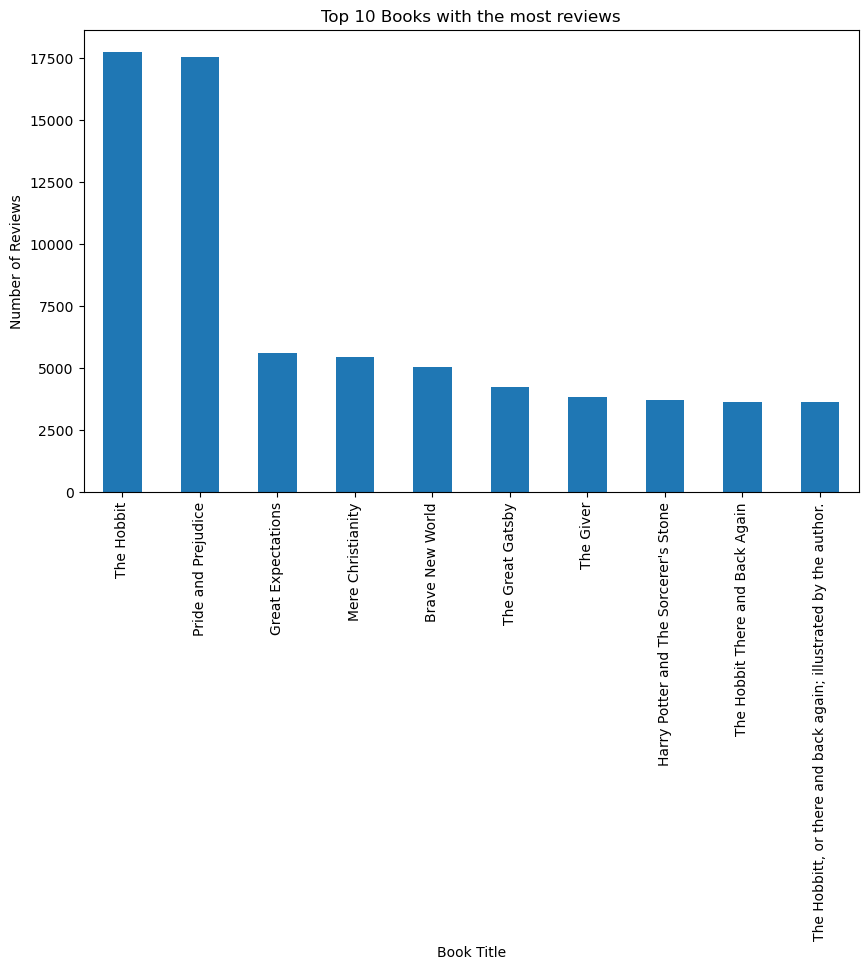

In [307]:
# plot the number of reviews per book
plt.figure(figsize=(10,6))
book_rating.groupby('BookTitle')['UserID'].count().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Top 10 Books with the most reviews')
plt.xlabel('Book Title')
plt.ylabel('Number of Reviews')
plt.show()

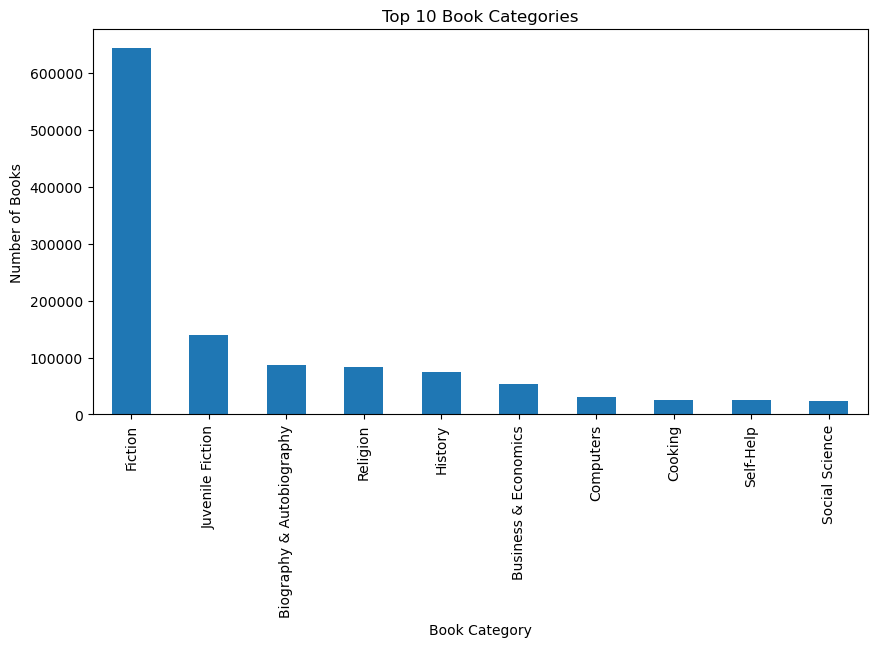

In [308]:
#plot the top 10 categories
plt.figure(figsize=(10,5))
book_rating["Book_Category"].value_counts()[:10].plot(kind='bar')
plt.title("Top 10 Book Categories")
plt.xlabel("Book Category")
plt.ylabel("Number of Books")
plt.show()


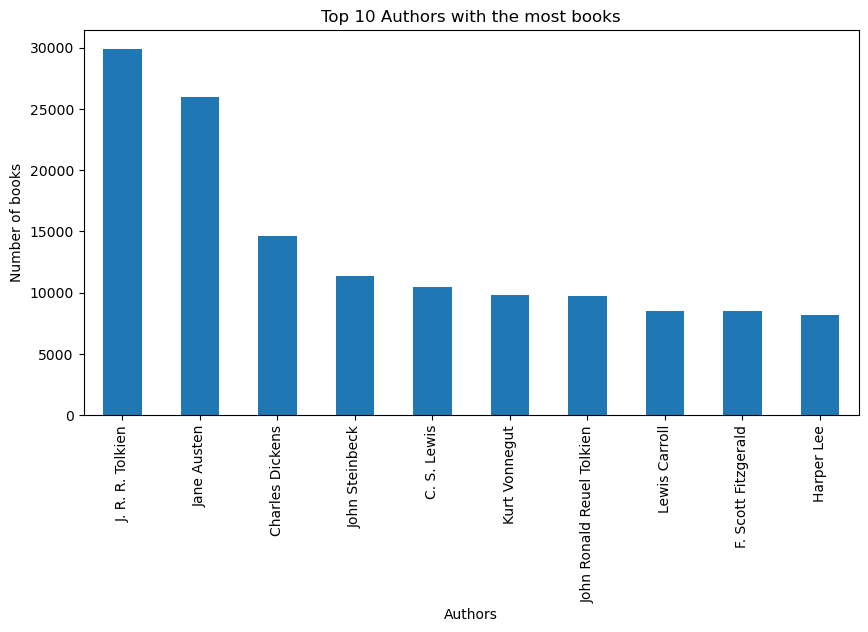

In [309]:
# plot the top 10 authors with the most books
plt.figure(figsize=(10,5))
book_rating["Main_Author"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Authors with the most books")
plt.xlabel("Authors")
plt.ylabel("Number of books")
plt.show()

## 5. Data for the Recommendation System <a class="anchor" id="_5"></a>

After multiple unsuccessful attempts to configure the data for the recommendation system, it became apparent that the extensive amount of data needed to be reduced for the project. Following several iterations, it was concluded that utilizing only 10% of the data would be the optimal approach.

In [310]:
# getting 10% sample of the merged data frame
book_rating_s= book_rating.sample(frac=0.1, replace=True, random_state=1)

# selecting the columns needed for the recommendation system
book_rating_s.shape

(178812, 12)

In [311]:
book_rating_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178812 entries, 128763 to 970894
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   BookTitle         178812 non-null  object 
 1   Book_Description  178812 non-null  object 
 2   Book_Category     178812 non-null  object 
 3   Published_Date    178812 non-null  object 
 4   Main_Author       178812 non-null  object 
 5   RatingID          178812 non-null  object 
 6   UserID            178812 non-null  object 
 7   Review_Score      178812 non-null  float64
 8   Review_Summary    178812 non-null  object 
 9   Review_Text       178812 non-null  object 
 10  Review_Counts     178812 non-null  int64  
 11  Average_Rating    178812 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 17.7+ MB


### 5.1 Transforming Data <a class="anchor" id="_5.1"></a>


Creating numerical values for the `UserID` and `BookTitle` columns

In [312]:
# assigne a numeric value to the user_id column
book_rating_s["UserID_"] = book_rating_s["UserID"].astype("category").cat.codes

# assigne a numeric value to the Title column
book_rating_s["BookTitle_"] = book_rating_s["BookTitle"].astype("category").cat.codes

book_rating_s.sample(3)

,BookTitle,Book_Description,Book_Category,Published_Date,Main_Author,RatingID,UserID,Review_Score,Review_Summary,Review_Text,Review_Counts,Average_Rating,UserID_,BookTitle_
1202471,All One Universe,Poul Anderson himself has put together a retro...,Fiction,1997-05-15,Poul Anderson,0812539095,A1V34YV8D0TNGP,4.0,Atoms and Unclefts,The reason I purchased this book was for the e...,5,4.000,29354,2501
580339,Vanity Fair (Bantam Classic),"""I do not say there is no character as well dr...",Fiction,2005-12-27,William Makepeace Thackeray,B000FCKLXY,A1APHERUJIKK3I,5.0,insightful and witty,Vanity Fair by William Makepeace ThackerayVani...,127,4.272,10180,45648
1683138,Microsoft .NET Platform and Technologies,This guide covers evaluating .NET: technical c...,Computers,2002,Curt Simmons,0130341789,A1RTSGY2749P9Z,3.0,Useful But Uneven Overview of .NET for Softwar...,In 254 pages prolific Microsoft technologies a...,2,3.000,26159,22929


---

## 6. Modeling Recommender Systems <a class="anchor" id="_6"></a>


### 6.1 User Independent System <a class="anchor" id="_6.1"></a>

Use it to find the most popular items, and recommend them to our user.

In [313]:
# creat a new df top_rated with BookTitle_, BookTitle, Book_Description, Average_Rating, and Review_Counts columns
top_rated = book_rating_s[["BookTitle_","BookTitle","Average_Rating","Review_Counts"]]
top_rated.head(3)


,BookTitle_,BookTitle,Average_Rating,Review_Counts
128763,40327,The Princess Bride,4.410299,1210
494478,39946,The Pdr Family Guide to Prescription Drugs 8th Ed,4.000000,4
473572,19244,Joy in the Morning,4.228571,178


In [314]:
top_rated.shape

(178812, 4)

In [315]:
# update the top_rated df with unique values of BookTitle_ and Book_Description
top_rated = top_rated.drop_duplicates(subset=['BookTitle_'], keep='first')
top_rated.shape

(48278, 4)

In [316]:
top_rated

,BookTitle_,BookTitle,Average_Rating,Review_Counts
128763,40327,The Princess Bride,4.410299,1210
494478,39946,The Pdr Family Guide to Prescription Drugs 8th Ed,4.000000,4
473572,19244,Joy in the Morning,4.228571,178
493986,28906,Return to Promise (Heart of Texas),3.750000,16
840772,29903,Scar Tissue,4.287975,317
...,...,...,...,...
1346725,6379,COIN LOCKER BABIES.,4.045455,22
690798,8162,Complete Sonnets,4.071429,14
1570655,32300,Stories I Wouldn't Tell Nobody But God,4.250000,16
462524,7604,Classic Four Block Applique Quilts,4.600000,5


In [317]:
# Finding the top rated books
top_rated = top_rated.sort_values(by=['Average_Rating'], ascending=False)
top_rated['BookTitle'].head(10)

432252     How to Read the Catechism of the Catholic Chur...
479310     Systematic Theology, vol. 2: Existence and the...
800683     If You Love Me, Don't Love Me: Undoing Recipro...
1589642                                       Holiday Baking
498034     Judgment on Nuremburg: American Attitudes Towa...
1073641                  Sweet & Simple Country Cross-Stitch
1131540    The Janowska Road (Also Published As 'The Deat...
538917                                    RIVER THROUGH TIME
959029                   Cam Jansen: The Ghostly Mystery #16
862673                                               Curries
Name: BookTitle, dtype: object

In [318]:
# These are the top rated books. However, they are not considering the number of reviews per book
top_rated.head(5)

,BookTitle_,BookTitle,Average_Rating,Review_Counts
432252,17017,How to Read the Catechism of the Catholic Chur...,5.0,1
479310,32863,"Systematic Theology, vol. 2: Existence and the...",5.0,6
800683,17651,"If You Love Me, Don't Love Me: Undoing Recipro...",5.0,2
1589642,16336,Holiday Baking,5.0,3
498034,19266,Judgment on Nuremburg: American Attitudes Towa...,5.0,1


- ##### **Thresholding**

In [319]:
threshold = 1000  # Set the threshold for the minimum number of reviews

# Filter the 'top_rated' DataFrame to include only books with review counts equal to or above the threshold
book_w_many_reviews_df = top_rated[top_rated['Review_Counts'] >= threshold]

# Sort the filtered DataFrame by 'Average_Rating' in descending order to get the top-rated books
top_rated_v2 = book_w_many_reviews_df.sort_values(by=['Average_Rating'], ascending=False)

# Display the top 5 books from the sorted DataFrame
top_rated_v2.head(5)


,BookTitle_,BookTitle,Average_Rating,Review_Counts
955698,15603,Harry Potter & the Prisoner of Azkaban,4.769741,1513
1186954,28656,Redeeming Love,4.745455,1210
112582,22004,Man's Search for Meaning,4.735404,2424
37349,1533,A Tree Grows in Brooklyn,4.714389,2776
467957,15606,Harry Potter and The Sorcerer's Stone,4.687938,3729


----

### 6.2 Content Based Recommendations <a class="anchor" id="_6.2"></a>

In [320]:
# create a new df for the content based recommendation system
content_df = book_rating_s[["BookTitle_","BookTitle","Book_Description","Average_Rating","Review_Counts"]]
content_df = content_df.drop_duplicates(subset=['BookTitle_'], keep='first')

In [321]:
# update the index of the content_df
content_df = content_df.reset_index(drop=True)
content_df.head(3)

,BookTitle_,BookTitle,Book_Description,Average_Rating,Review_Counts
0,40327,The Princess Bride,"In a twenty-fifth anniversary, behind-the-scen...",4.410299,1210
1,39946,The Pdr Family Guide to Prescription Drugs 8th Ed,"Based on the Physicians' Desk Reference, the n...",4.000000,4
2,19244,Joy in the Morning,A timeless classic is reborn! From Betty Smith...,4.228571,178


In [322]:
df_descriptions = content_df[['BookTitle', 'Book_Description']]
df_descriptions.head(5)

,BookTitle,Book_Description
0,The Princess Bride,"In a twenty-fifth anniversary, behind-the-scen..."
1,The Pdr Family Guide to Prescription Drugs 8th Ed,"Based on the Physicians' Desk Reference, the n..."
2,Joy in the Morning,A timeless classic is reborn! From Betty Smith...
3,Return to Promise (Heart of Texas),"Come back again to Promise, Texas, in this cla..."
4,Scar Tissue,"In this ""vivid and inspiring"" NYT bestseller (..."


In [323]:
vectorizer = TfidfVectorizer(stop_words = "english", min_df=2)
content_df['Book_Description'] = content_df['Book_Description'].fillna("")

TF_IDF_matrix = vectorizer.fit_transform(content_df['Book_Description'])

In [324]:
TF_IDF_matrix.shape

(48278, 56555)

In [325]:
content_df[content_df['BookTitle'].str.contains('Harry Potter', na=False)].head(8)

,BookTitle_,BookTitle,Book_Description,Average_Rating,Review_Counts
530,15607,Harry Potter and the Chamber of Secrets,"Witchcraft, wizardry - fiction.",4.672855,1572
1214,15603,Harry Potter & the Prisoner of Azkaban,"Through classroom activities, wizard rock conc...",4.769741,1513
1891,15606,Harry Potter and The Sorcerer's Stone,Celebrate 20 years of Harry Potter magic! Harr...,4.687938,3729
3127,40971,The Science of Harry Potter: How Magic Really ...,A look at the scientific principles underpinni...,3.523810,21
9716,15604,Harry Potter Hogwarts School: A Magical 3-D Ca...,"Magic abounds in this tall, deluxe pop-up caro...",5.000000,8
18785,15605,Harry Potter and Philosophy: If Aristotle Ran ...,Urging readers of the Harry Potter series to d...,4.192308,26
20234,15609,Harry Potter et le prisonnier d'Azkaban,"Sirius Black, le dangereux criminel qui s’est ...",4.714286,14
21501,15608,Harry Potter and the Prisoner of Azkaban 2005 ...,"Now in its twentieth edition, a concise guide ...",4.333333,3


In [326]:
book_1 = TF_IDF_matrix[(content_df['BookTitle'] == 'Harry Potter & the Prisoner of Azkaban').values,]
book_2 = TF_IDF_matrix[(content_df['BookTitle'] == "Harry Potter and The Sorcerer's Stone").values,]

print("Similarity:", cosine_similarity(book_1, book_2)) 

Similarity: [[0.32375119]]


In [327]:
book_1 = TF_IDF_matrix[(content_df['BookTitle'] == 'Harry Potter & the Prisoner of Azkaban').values,]
book_3 = TF_IDF_matrix[(content_df['BookTitle'] == "Harry Potter et le prisonnier d'Azkaban").values,]

print("Similarity:", cosine_similarity(book_1, book_3)) 

Similarity: [[0.16951278]]


In [328]:
similarities = cosine_similarity(TF_IDF_matrix, dense_output=False)

In [329]:
similarities.shape

(48278, 48278)

In [330]:
# Test with a sample book
content_df[content_df['BookTitle'] == 'Harry Potter & the Prisoner of Azkaban']

,BookTitle_,BookTitle,Book_Description,Average_Rating,Review_Counts
1214,15603,Harry Potter & the Prisoner of Azkaban,"Through classroom activities, wizard rock conc...",4.769741,1513


In [331]:
content_df.shape

(48278, 5)

In [332]:
# Get the column based upon the index
book_index = content_df[content_df['BookTitle'] == 'Harry Potter & the Prisoner of Azkaban'].index

# Create a dataframe with the book titles
sim_df = pd.DataFrame({'book':content_df['BookTitle'], 
                       'similarity': np.array(similarities[book_index, :].todense()).squeeze()})

In [333]:
# Return the top 10 most similar books
sim_df.sort_values(by='similarity', ascending=False).head(10)

,book,similarity
1214,Harry Potter & the Prisoner of Azkaban,1.000000
25942,Harry Potter und der Gefangene von Azkaban,0.386375
30457,The Sorcerer's Companion: A Guide to the Magic...,0.338209
35265,Critical Perspectives on Harry Potter,0.329599
1891,Harry Potter and The Sorcerer's Stone,0.323751
38275,There's Something About Harry: A Catholic Anal...,0.284528
3127,The Science of Harry Potter: How Magic Really ...,0.259456
21981,An Unofficial Muggle's Guide to the Wizarding ...,0.254043
38850,Science of Harry Potter: How Magic Really Works,0.231103
18785,Harry Potter and Philosophy: If Aristotle Ran ...,0.223275


In [334]:
def content_recommender(title, books, similarities, vote_threshold=10) :
    
    # Get the book by the title
    book_index = content_df[content_df['BookTitle'] == title].index
    
    # Create a dataframe with the book titles
    sim_df = pd.DataFrame(
        {'books': books['BookTitle'], 
         'similarity': np.array(similarities[book_index, :].todense()).squeeze(),
         'Review_Counts': books['Review_Counts']
        })
    
    # Get the top 10 books with > 10 votes
    top_books = sim_df[sim_df['Review_Counts'] > vote_threshold].sort_values(by='similarity', ascending=False).head(10)
    
    return top_books

In [335]:
# Test the recommender
similar_books = content_recommender("Harry Potter & the Prisoner of Azkaban", content_df, similarities, vote_threshold=1000)
similar_books.head(10)

,books,similarity,Review_Counts
1214,Harry Potter & the Prisoner of Azkaban,1.000000,1513
1891,Harry Potter and The Sorcerer's Stone,0.323751,3729
620,Jane Eyre (New Windmill),0.053729,1189
0,The Princess Bride,0.038248,1210
706,The Hobbit There and Back Again,0.024916,3675
1188,Alice's Adventures in Wonderland,0.022321,2817
155,The Hitchhiker's Guide to the Galaxy,0.020917,2698
220,"The Hobbitt, or there and back again; illustra...",0.019332,3658
216,Dracula (G. K. Hall (Large Print)),0.018415,1034
1828,Catch-22,0.018199,1603


### 6.3 Collaborative Based Recommendations - NEEDS WORK

In [369]:
# create a new df for the collaborative based recommendation system
collab_df = book_rating_s[["UserID_","BookTitle_","Review_Score"]]

#order the df by UserID_ and BookTitle_
collab_df = collab_df.sort_values(by=['UserID_','BookTitle_'], ascending=True)

collab_df.head(10)

,UserID_,BookTitle_,Review_Score
400891,0,17076,5.0
375919,1,37693,5.0
1435184,1,37694,5.0
777439,2,944,5.0
752192,2,19229,5.0
812562,3,38560,5.0
361369,4,37693,5.0
366044,4,37693,5.0
1131418,5,42637,5.0
799182,5,42638,5.0


In [337]:
# filter the collab_df to include only the users with more than 5 reviews
collab_df = collab_df.groupby("UserID_").filter(lambda x: len(x) >= 5)

# update the index of the collab_df starting from 1
collab_df = collab_df.reset_index(drop=True)

collab_df.shape

(25631, 3)

In [338]:
collab_df

,UserID_,BookTitle_,Review_Score
0,153,7664,5.0
1,153,16204,5.0
2,153,28700,5.0
3,153,28700,5.0
4,153,33689,5.0
...,...,...,...
25626,128456,579,5.0
25627,128456,6676,5.0
25628,128456,13682,5.0
25629,128456,39015,5.0


#### Utility Matrix

In [339]:
users = collab_df['UserID_'].unique()
books = collab_df['BookTitle_'].unique()

num_users = len(users)
num_books = len(books)

R = np.full((num_users, num_books), np.nan)

for row in collab_df.itertuples():
    user = row[1]
    book = row[2]
    rating = row[3]
    R[user-1, book-1] = rating

    
R_df = pd.DataFrame(data=R, index=range(1, num_users+1), columns=range(1, num_books+1))

IndexError: index 16203 is out of bounds for axis 1 with size 12153

In [ ]:
users = collab_df['UserID_'].unique()
books = collab_df['BookTitle_'].unique()

num_users = len(users)
num_books = len(books)

In [ ]:
num_users, num_books

In [ ]:
# np.nan means they user has not reviewed the movie
R = np.full((num_users, num_books), np.nan)
R.shape

In [ ]:
#Build the user-item matrix
for row in collab_df.itertuples(): # same as zip(df.index, df["user"], df["movie"], df["score"])
    user = row[1]
    book = row[2]
    rating = row[3]
    R[user-1, book-1] = rating
    
R_df = pd.DataFrame(data=R, index=range(1, num_users+1), columns=range(1, num_books+1))

In [ ]:
users = collab_df['UserID_'].unique()
books = collab_df['BookTitle_'].unique()

num_users = len(users)
num_books = len(books)
           
# np.nan means they user has not reviewed the movie
R = np.full((num_users, num_books), np.nan)

#Build the user-item matrix
for row in collab_df.itertuples(): # same as zip(df.index, df["user"], df["movie"], df["score"])
    user = row[1]
    book = row[2]
    rating = row[3]
    R[user-1, book-1] = rating
    
R_df = pd.DataFrame(data=R, index=range(1, num_users+1), columns=range(1, num_books+1))

In [ ]:
users = collab_df['UserID_'].unique()
books = collab_df['BookTitle_'].unique()

num_users = len(users)
num_books = len(books)

# np.nan means the user has not reviewed the books
R = np.full((num_users, num_books), np.nan)

# Build the user-item matrix
for row in collab_df.itertuples():
    user = row[1]
    book = row[2]
    rating = row[3]
    book_index = np.where(books == book)[0][0]  # Find the index of the book title
    R[user-1, book_index] = rating

R_df = pd.DataFrame(data=R, index=range(1, num_users+1), columns=books)


In [ ]:
R_df

#### Identify users with the most reviews

#### Similar Users

In [ ]:
R_df.loc[5, :]

In [ ]:
R_df.loc[48, :]

In [ ]:
### Similar Users
books_1st_user_rated = ~R_df.loc[5, :].isna()
books_2nd_user_rated = ~R_df.loc[48, :].isna()

books_both_users_rated = books_1st_user_rated & books_2nd_user_rated
print(books_both_users_rated.sum())

In [ ]:
print("Reviewers' scores:")
R_df.loc[[5, 48], books_both_users_rated]

In [ ]:
print("Similarity:", cosine_similarity(R_df.loc[5, books_both_users_rated].values.reshape(1,-1), 
                                       R_df.loc[48, books_both_users_rated].values.reshape(1,-1)))

In [ ]:
### Making Predictions

def find_user_similarity(user_1, user_2, R_df):
    
    # Define the mask which finds all movies they rated together
    books_1st_user_rated = ~R_df.loc[user_1, :].isna()
    books_2nd_user_rated = ~R_df.loc[user_2, :].isna()

    books_both_users_rated = books_1st_user_rated & books_2nd_user_rated

    # Sum boolean to get the counts
    number_of_books_rated_together = books_both_users_rated.sum()
        
    # Find the ratings of both users for movies they both watched
    ratings_of_user1 = R_df.loc[user_1, books_both_users_rated].values.reshape(1, -1)
    ratings_of_user2 = R_df.loc[user_2, books_both_users_rated].values.reshape(1, -1)
    
    # Finally, calculate the similarity between them
    similarity = cosine_similarity(ratings_of_user1, ratings_of_user2)[0][0]
    
    return similarity, number_of_books_rated_together

In [ ]:
current_user = 4531 # we will only do this to user 16 for demonstration purposes
current_book = 4531
similarities_to_user_16 = []
ratings_given_to_book_2 = []

# Find only the users who rated movie 2 (rows)
R_df2 = R_df[~R_df.iloc[:, 1].isna()].copy()

for other_user in R_df2.index:
    
    similarity, number_of_books_rated_together = find_user_similarity(current_user, other_user, R_df)
    similarities_to_user_16.append(similarity)
    ratings_given_to_book_2.append(R_df.loc[other_user, current_book])
            
# Finally, let's turn these into numpy arrays so life is easier
similarities_to_user_16 = np.array(similarities_to_user_16)
ratings_given_to_book_2 = np.array(ratings_given_to_book_2)

### 6.4 Matrix Factorization Methods and Latent Features - NEEDS WORK

#### Funk Singular Value Decomposition (FunkSVD)

In [340]:
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD

In [351]:
# create a new df for the FunkSVD recommendation system
funk_df = book_rating_s[["UserID_","BookTitle_","Review_Score"]]

#order the df by UserID_ and BookTitle_
funk_df = funk_df.sort_values(by=['UserID_','BookTitle_'], ascending=True)

# filter the collab_df to include only the users with more than 5 reviews
funk_df = funk_df.groupby("UserID_").filter(lambda x: len(x) >= 5)

funk_df.head(10)

,UserID_,BookTitle_,Review_Score
174482,153,7664,5.0
238598,153,16204,5.0
1547173,153,28700,5.0
1547173,153,28700,5.0
726001,153,33689,5.0
548525,204,218,4.0
422548,204,396,5.0
1023762,204,599,2.0
132639,204,2402,4.0
1065690,204,4197,5.0


In [352]:
my_dataset = Dataset.load_from_df(funk_df, Reader(rating_scale=(1, 5)))
my_train_dataset = my_dataset.build_full_trainset()

In [353]:
my_train_dataset

In [354]:
my_algorithm = FunkSVD(n_factors=10, 
                       n_epochs=100, 
                       lr_all=0.1,    # Learning rate for each epoch
                       biased=False,  # This forces the algorithm to store all latent information in the matrices
                       verbose=0)

my_algorithm.fit(my_train_dataset)

In [360]:
# User Matrix
U = my_algorithm.pu
U.shape

# Book Matrix
B = my_algorithm.qi.T
B.shape

print("User Matrix Shape:", U.shape)
print("User Book Shape:", B.shape)

User Matrix Shape: (2517, 10)
User Book Shape: (10, 12153)


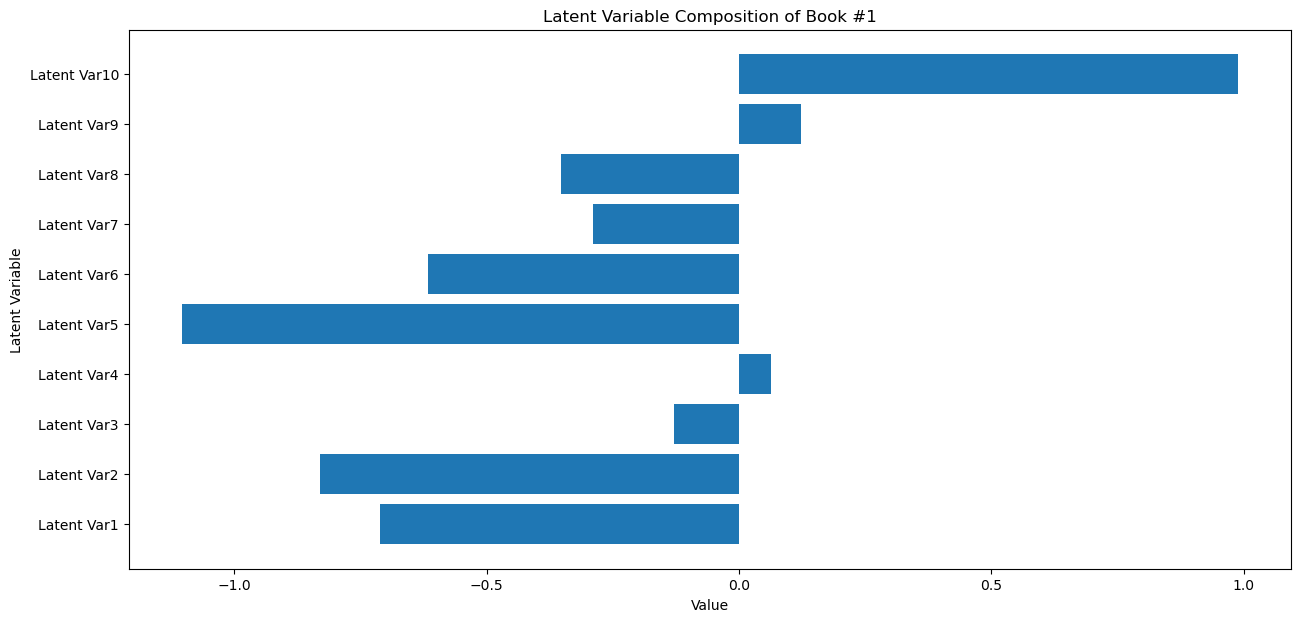

In [359]:
first_book = B[:, 0]

plt.figure(figsize=(15, 7))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_book)+1)], first_book)
plt.title("Latent Variable Composition of Book #1")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

In [362]:
inner_user_id = my_train_dataset.to_inner_uid(153) # find the inner representation of user 1
user_profile = U[inner_user_id]
user_profile

array([-0.86663012, -0.98880424, -0.15221115,  0.00160331, -1.34677748,
       -0.77473034, -0.45042532, -0.41201296,  0.09458753,  1.27929464])

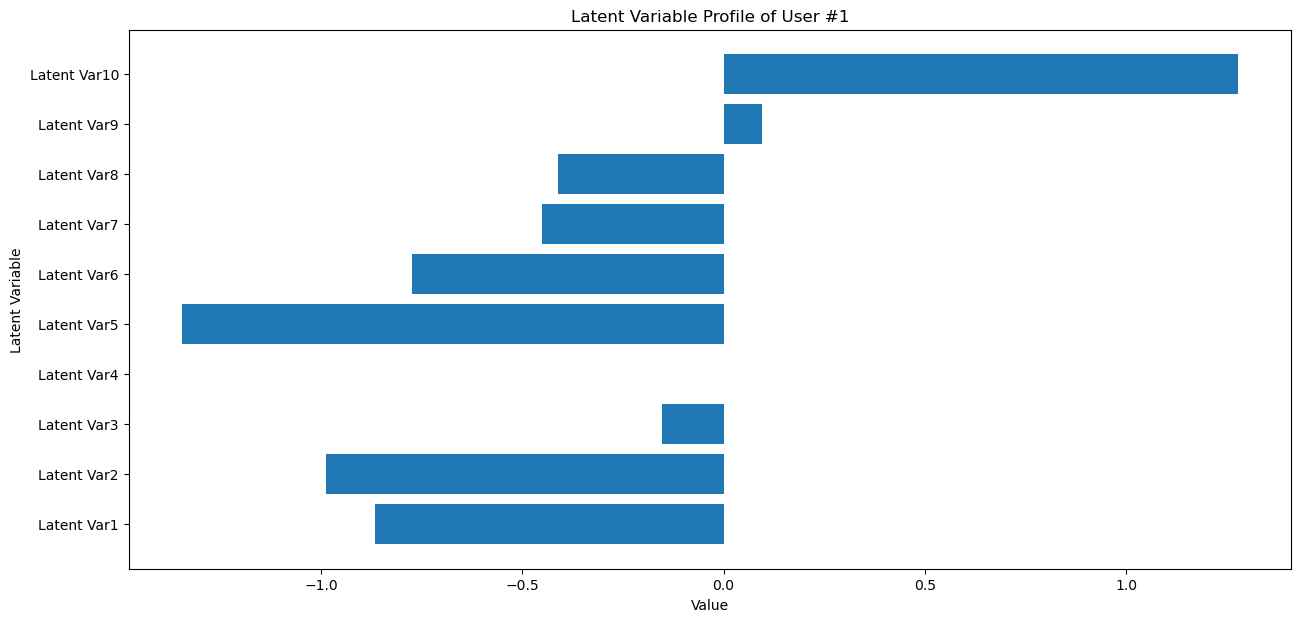

In [363]:
plt.figure(figsize=(15, 7))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_book)+1)], user_profile)
plt.title("Latent Variable Profile of User #1")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

In [364]:
inner_book_id = my_train_dataset.to_inner_iid(2) # find the inner representation of item 1
book_profile = M[:, inner_book_id]
book_profile

array([ 1.41344157e-01,  2.74411669e-01,  9.25984376e-02, -5.68455016e-01,
       -8.86023348e-01,  4.25964804e-01, -3.52115636e-04, -4.36989229e-01,
        1.36687639e+00,  5.90568770e-01])

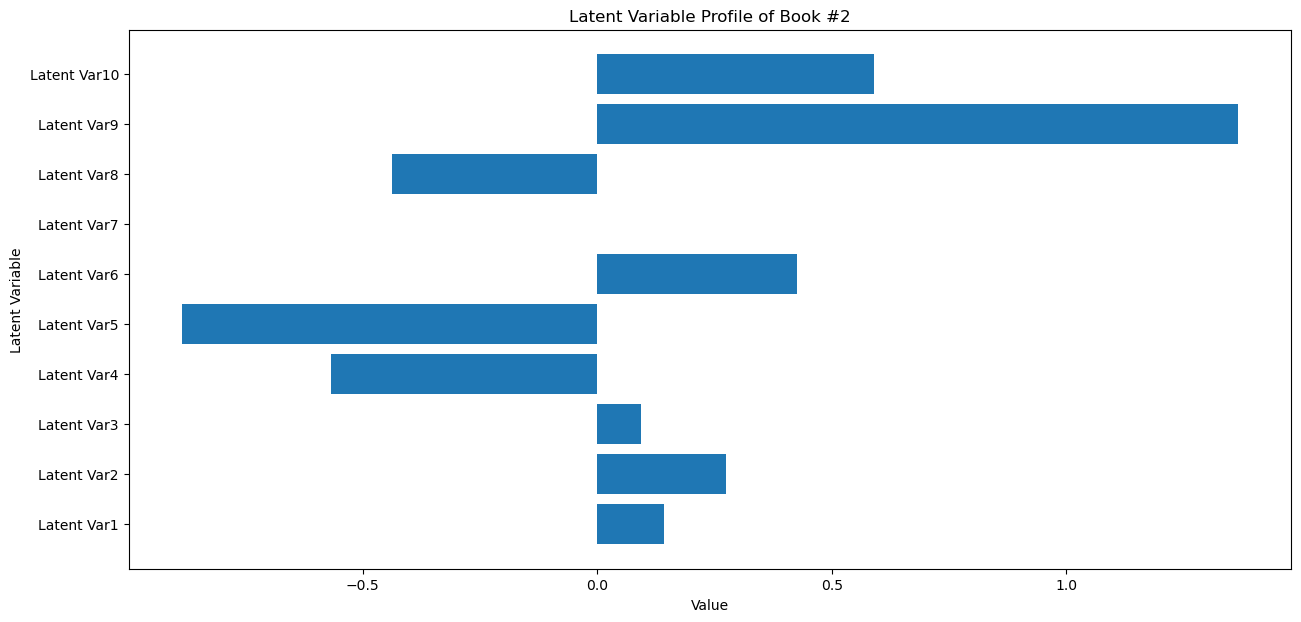

In [366]:
plt.figure(figsize=(15, 7))
plt.barh([f'Latent Var{i}' for i in range(1,len(first_book)+1)], book_profile)
plt.title("Latent Variable Profile of Book #2")
plt.ylabel("Latent Variable")
plt.xlabel("Value")
plt.show()

In [368]:
expected_rating = np.dot(user_profile, book_profile)
expected_rating

1.5194347369610393